In [6]:
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
log_file1 = '/data/slcao_data/zlt/RemoteSensePET/outputs/Ship/tiny_noencoder/run_log.txt'
log_file2 = '/data/slcao_data/zlt/RemoteSensePET/outputs/Ship/tiny_noencoder_attnsplit/run_log.txt'
log_file3 = '/data/slcao_data/zlt/RemoteSensePET/outputs/Ship/tiny_noencoder_opre/run_log.txt'
log_file4 = '/data/slcao_data/zlt/RemoteSensePET/outputs/Ship/tiny_noencoder_attnsplit_opre/run_log.txt'

# epochs = []
# train_losses = []
# best_maes = []
# best_epochs = []

In [8]:
def check_convergence(loss_list, window_size=10, relative_threshold=0.01, std_threshold=0.01):
    if len(loss_list) < window_size + 1:
        return False
    recent_losses = loss_list[-(window_size + 1):]
    
    relative_changes = []
    for i in range(1, len(recent_losses)):
        prev = recent_losses[i-1]
        curr = recent_losses[i]
        if prev != 0:
            change = abs(curr - prev) / prev
        else:
            change = abs(curr - prev)
        relative_changes.append(change)
    
    std_value = np.std(recent_losses)
    relative_change_pass = all(change < relative_threshold for change in relative_changes)
    std_pass = std_value < std_threshold

    return relative_change_pass #and std_pass

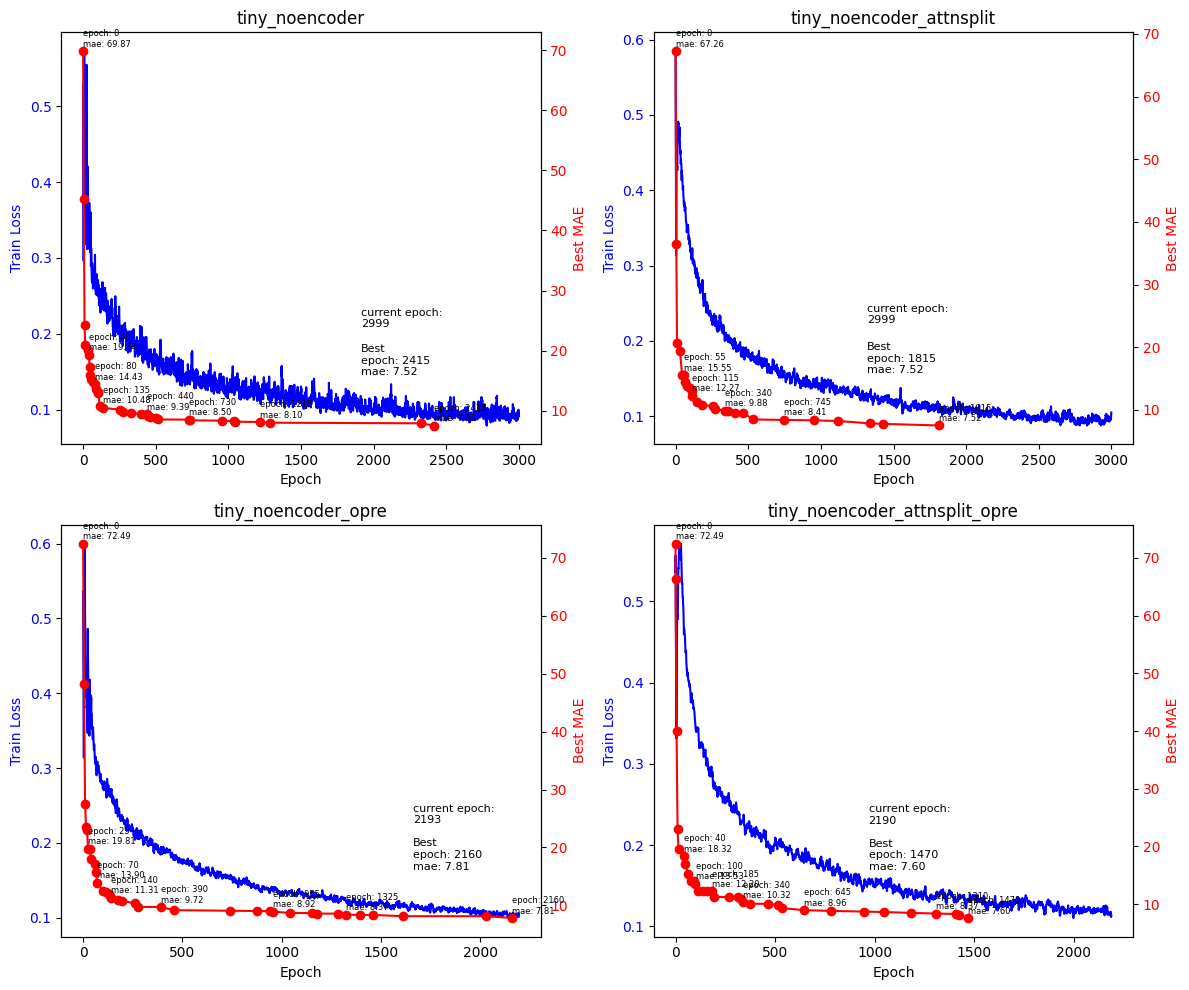

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10)) 

p_x = 0
p_y = 0

for log_file in [log_file1, log_file2, log_file3, log_file4]:
    epochs = []
    train_losses = []
    best_maes = []
    best_epochs = []
    with open(log_file, 'r') as f:
        current_best_mae = float('inf')
        for line in f:
            if '[ep' in line:
                json_str = re.search(r'{.*}', line)
                if json_str:
                    data = json.loads(json_str.group())
                    epochs.append(data['epoch'])
                    train_losses.append(data['train_loss'])
            
            elif 'best mae' in line:
                best_info = re.search(r'best mae:(\d+\.\d+), best epoch: (\d+)', line)
                if best_info:
                    mae = float(best_info.group(1))
                    epoch = int(best_info.group(2))
                    if mae < current_best_mae:
                        current_best_mae = mae
                        best_maes.append(mae)
                        best_epochs.append(epoch)
                        
    window = 5
    train_losses_smoothed = pd.Series(train_losses).ewm(span=window, adjust=False).mean().values
     
    ax1 = axs[p_y, p_x]  
    if p_x == 0:
        p_x += 1
    elif p_y == 0:
        p_x = 0
        p_y += 1
        
    ax1.plot(epochs, train_losses_smoothed, label='Smoothed Train Loss', color='blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
        
    # window_size = 50
    # for i in range(len(train_losses_smoothed) - window_size):
    #     window_losses = train_losses_smoothed[i:i+window_size+1]
    #     if check_convergence(window_losses, window_size=window_size, relative_threshold=0.01, std_threshold=0.01):
    #         # print('cv')
    #         ax1.axvspan(epochs[i], epochs[i+window_size], color='yellow', alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(best_epochs, best_maes, label='Best MAE', color='red', marker='o')
    count_print = 0
    for x, y in zip(best_epochs, best_maes):
        if count_print % 5 == 0 or x == best_epochs[-1]:
            ax2.text(x + 0.5, y + 0.4, f'epoch: {x}\nmae: {y:.2f}', fontsize=6, ha='left', va='bottom')
        count_print += 1

    log_name = log_file.split('/')[-2]
    ax2.text(x -500 , y + 8, f'Best\nepoch: {x}\nmae: {y:.2f}', fontsize=8, ha='left', va='bottom')
    ax2.text(x -500 , y + 16, f'current epoch:\n{epochs[-1]}', fontsize=8, ha='left', va='bottom')
    ax2.set_ylabel('Best MAE', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    ax1.set_title(f'{log_name}')

fig.savefig('ex_0429_ship.pdf', bbox_inches='tight')
plt.show()
